### 线性回归从零开始
生成一个包含1000个样本的数据集， 每个样本包含从标准正态分布中采样的2个特征。 合成数据集是一个矩阵， $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$
使用线性模型参数 $\mathbf{w} = [2, -3.4]^\top$ 和噪声项e生成数据集及其标签 $\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$

features中的每一行都包含一个二维数据样本， labels中的每一行都包含一维标签值

In [14]:
import torch
import random

##### *1、生成数据集*

In [11]:
def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(mean=0, std=1, size=(num_examples, len(w))) # 生成x，从标准正态分步采样1000,2的矩阵
    y = torch.matmul(X, w) + b                                   # 生成y，使用公式y = X * w + b，矩阵相乘
    y += torch.normal(0, 0.01, y.shape)                          # 生成e，模拟误差
    return X, y.reshape((-1, 1))    # 改变形状，变成二维矩阵，1000行，每行一个值

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print(f'1000X2 features : {features.shape}, 1000X1 labels : {labels.shape}')
print('features[0]:', features[0],'\tlabel[0]:', labels[0])

1000X2 features : torch.Size([1000, 2]), 1000X1 labels : torch.Size([1000, 1])
features[0]: tensor([ 1.9845, -1.4676]) 	label[0]: tensor([13.1671])


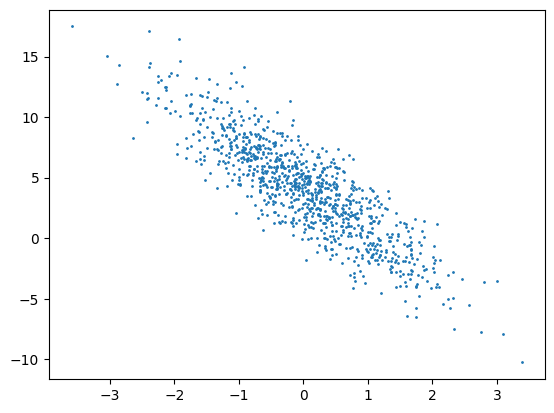

In [13]:
import matplotlib.pyplot as plt
plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

#### *2、读取数据集*
对数据集进行遍历，每次抽取一小批量样本，该函数能打乱数据集中的样本并以小批量方式获取数据。data_iter函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签

In [15]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

#### *3、初始化模型参数*
初始化w, b参数，训练从初始化参数开始，不停的更新这些参数，直到这些参数足够拟合我们的数据。 

In [19]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)  #requires_grad=True，计算梯度
b = torch.zeros(1, requires_grad=True)

w, b

(tensor([[4.2757e-05],
         [1.2472e-02]], requires_grad=True),
 tensor([0.], requires_grad=True))

#### *4、定义模型*
根据输入和参数计算输出，生成预测值。 $\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$

In [20]:
def linreg(X, w, b):  
    """线性回归模型"""
    return torch.matmul(X, w) + b

#### *5、定义损失函数*
计算预测值与真实值差值的函数

In [21]:
def squared_loss(y_hat, y):  
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

#### *6、定义优化算法*
根据损失函数调整参数w、b，目标是损失函数的梯度最小。

In [22]:
def sgd(params, lr, batch_size):  # 参数，学习率，批次大小
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

#### *7、训练*
在每次迭代中，读取一小批量训练样本，并通过模型来获得一组预测值。 然后根据真实值和预测值对比，计算完损失后，我们开始反向传播，存储每个参数的梯度。 最后，调用优化算法sgd来更新模型参数。

* 初始化参数
* 重复以下训练，直到完成

    - 计算梯度：$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$

    - 更新参数：$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In [23]:
lr = 0.03                   # 学习率 0.03
num_epochs = 3              # 学习轮数 3
net = linreg                # 网络模型
loss = squared_loss         # 损失函数
batch_size = 10             # 批次大小
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):  #遍历数据
        l = loss(net(X, w, b), y)    # X和y的小批量损失
        l.sum().backward()           # 计算损失函数的梯度
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.039043
epoch 2, loss 0.000150
epoch 3, loss 0.000051


## 使用PyTorch框架简洁实现

In [26]:
import torch
from torch.utils import data

# 1、生成数据集
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

# 2、读取数据集
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

# 3、定义模型
# Sequential类将多个层串联在一起。Linear两个参数，输入特征形状2和输出特征形状1
net = torch.nn.Sequential(torch.nn.Linear(2, 1))  

# 4、初始化模型参数
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

# 5、定义损失函数
loss = torch.nn.MSELoss()

# 6、定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

# 7、开始训练
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

# 8、推理
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

epoch 1, loss 0.000281
epoch 2, loss 0.000099
epoch 3, loss 0.000099
w的估计误差： tensor([0.0004, 0.0004])
b的估计误差： tensor([0.0002])
